# Extreme Value Analysis of S&P500
When will the bass drop? When will it not stonks? Will you lose your tendies?

# Fisher–Tippett–Gnedenko theorem or Extreme Value Theorem (EVT)
This is a handy dandy way of modelling asymptotic distributions so we can make sense of extreme/tail values. It's similar to the Central Limit Theorem (CLT). 

Instead of 'mean' in CLT, we model the 'maxima' in EVT. 

Instead of 'Normal' in CLT, we model 'Generalized Extreme Value'. 

Eg. $N \sim (\mu, \sigma)$ vs $GEV \sim (\mu, \sigma, \xi)$  
  
<br/>  
  
**Definition**

Let $X_{1}, X_{2}, ..., X_{n}$ be independent and identically distributed random variables (iid).

Each of the $X_{i}$ variables are sampled from an underlying distribution function $F$. 

Let $M_{n}$ be the maximum value of the iid variables. So, $M_{n} = max(X_{1}, X_{2}, ... , X_{n})$

Consider two sets of real numbers where $a_{n} \in \mathbb R_{>0}$ and $b_{n} \in \mathbb R$ such that $\frac{M_{n} - b_{n}}{a_{n}}$ has a non-degenerate limiting distribution as $n \to \infty$. Consider $x \in \mathbb R$ as some point of convergence, then $G(x)$ is as follows:

$G(x) = \lim_{n \to \infty} P( \frac{M_{n} - b_{n}}{a_{n}} \geq x )$

<br />

$G(x)$ can be parameterized should it converge, details found in Fisher-Tippett-Gnedenko proof.

$a$ is the location parameter to shift the distribution right or left. This acts like the "mean" in CLT so we will just call it $\mu$.

$b$ is the scale parameter to determin the spread. This acts like the standard deviation in CLT so we will just call it $\sigma$.

$\xi$ is the shape paramater of the Generalized Extreme Value Distribution. 

<br />

$\xi < 0$ is called the Weibull distribution

$\xi = 0$ is called the Gumbel distribution

$\xi > 0$ is called the Fréchet distribution

<br />

$GEV \sim (\mu, \sigma, \xi)$ = $G_{\mu,\sigma,\xi}(x)$ = $exp(-(1 + \xi \frac{x - \mu}{\sigma})^{-1/\xi})$

### Key Assumptions
1. We assume independence of samples. This is a huge assumption that will affect the quality of results.

2. We assume that samples are taken from the same underlying distribution. This doesn't account for seasonality in data. In addition, This doesn't account for stationarity in the time series.

3. We assume that the samples are random. Measurements are unbiased estimators of some phenomenon. What if the world is being manipulated by some secret elite group or lizard people??? 🤔🤔🤔

# Python Modelling

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lmoments3
from lmoments3 import distr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from arch.univariate import GARCH, ConstantMean, Normal
from arch import arch_model
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)

### Describe Data
Obtain S&P500 monthly data and get a general idea of the data

In [2]:
df = pd.read_csv("monthly.csv")

# Strip return column of % and convert to float
df['Return (%)'] = df['Return (%)'].str.rstrip('%').astype('float') / 100.0

In [3]:
df.describe()

,Year,Month,Return (%)
count,1445.000000,1445.000000,1445.000000
mean,1959.709343,6.487889,0.005255
std,34.773883,3.454396,0.042731
min,1900.000000,1.000000,-0.264700
25%,1930.000000,3.000000,-0.014600
50%,1960.000000,6.000000,0.008500
75%,1990.000000,9.000000,0.029200
max,2020.000000,12.000000,0.503000


### Visualize Data

**Line Plot of Monthly Returns**

<AxesSubplot:xlabel='Year', ylabel='Return (%)'>

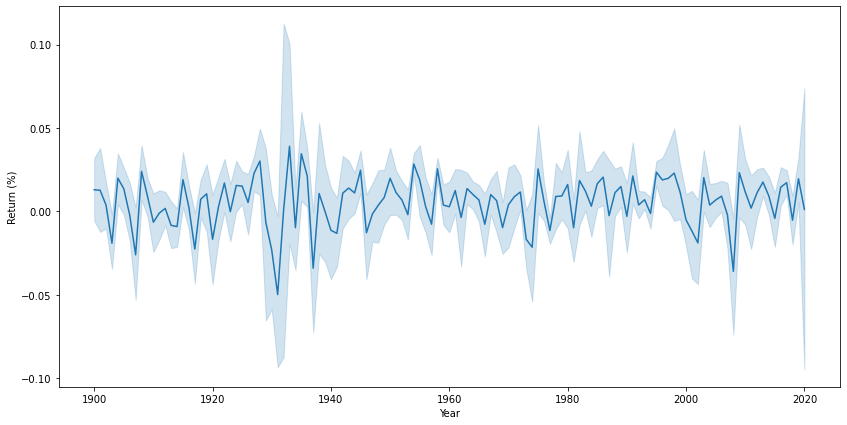

In [4]:
sns.lineplot(
    x='Year', 
    y='Return (%)',
    data=df
)

**Dist Plot of Monthly Returns**

<AxesSubplot:xlabel='Return (%)'>

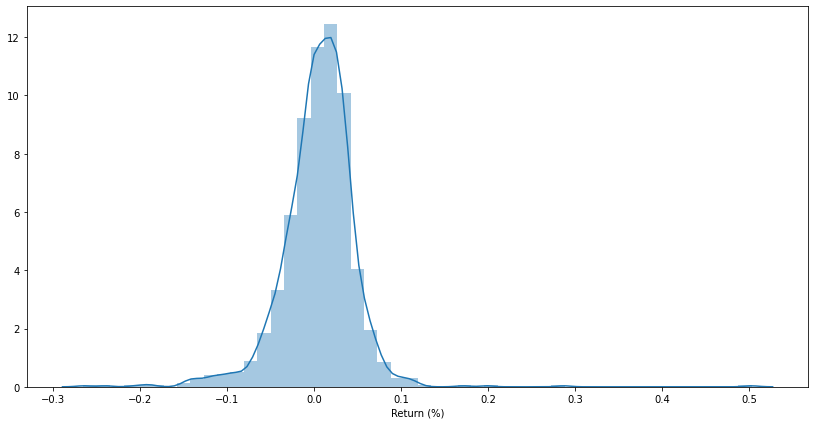

In [5]:
sns.distplot(
    a=df['Return (%)']
)

**Boxen Plot**

<AxesSubplot:xlabel='Year', ylabel='Return (%)'>

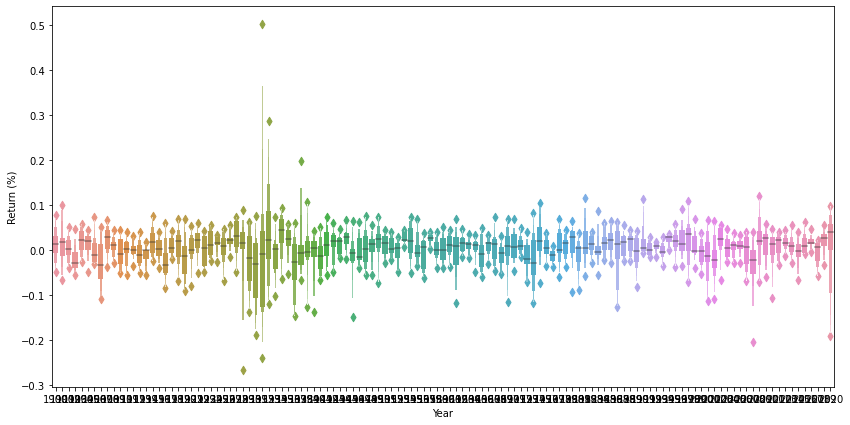

In [6]:
sns.boxenplot(
    x='Year', 
    y='Return (%)',
    data=df
)

### Block Maxima Approach

In a given block (eg. year), what's the likelihood of an exceedance of a specified threshold

In [7]:
# Extract Maxima (in this case we want minima because we want to check for crashes)
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f'Start Year: {min_year} \t End Year: {max_year-1} (omit 2020 as it is not complete)')

years = np.arange(min_year, max_year)
min_returns = np.zeros(len(years))

for i in range(len(years)):
    # Invert the values to get maxima
    min_returns[i] = df[df['Year'] == min_year + i].min()['Return (%)']

# We don't actually need this
min_df = pd.DataFrame({'Year': years, 'Min Return': min_returns})
min_df

Start Year: 1900 	 End Year: 2019 (omit 2020 as it is not complete)


,Year,Min Return
0,1900,-0.0473
1,1901,-0.0671
2,1902,-0.0385
3,1903,-0.0553
4,1904,-0.0269
...,...,...
115,2015,-0.0660
116,2016,-0.0074
117,2017,-0.0032
118,2018,-0.0573


In [8]:
lmoms = lmoments3.lmom_ratios(min_returns,4)
print('l-moments:', lmoms)
gev = distr.gev
params = gev._lmom_fit(lmoms)

print(f'GEV parameters: {params}')

l-moments: [-0.058575, 0.022864425770308137, -0.2952298349603621, 0.2351013736313552]
GEV parameters: OrderedDict([('c', 0.9031893979803313), ('loc', -0.0604703088776545), ('scale', 0.046094060841909)])


In [9]:
gev._lmom_ratios(
    c=params['c'],
    loc=params['loc'],
    scale=params['scale'],
    nmom=4
)


[-0.058575, 0.022864425770308137, -0.29522982571313205, 0.14966584415733797]

What's the likelihood of a crash in any given year? Use 20% as the threshold of a crash. Where 20% is used as the L3 circuit breaker. 

In [10]:
# Calculate cdf of gev, adapted from lmoments https://github.com/samgillespie/Python-L-Moments/blob/master/lmom.py
def cdfgev(x, c, loc, scale):
    SMALL = 1e-15
    U=loc
    A=scale
    G=c
    if A <= 0:
        print("Parameters Invalid")
        return
    Y = (x-U)/A
    if G==0:
        CDFGEV = np.exp(-np.exp(-Y))
    else:
        Arg = 1-G*Y
        if Arg > SMALL:
            Y = -np.log(Arg)/G
            CDFGEV = np.exp(-np.exp(-Y))
        elif G<0:
            CDFGEV = 0
        else:
            CDFGEV = 1

    return(CDFGEV)

# using 0.20 (20%) exceedance
prob = cdfgev(-0.2, params['c'], params['loc'], params['scale'])
print(f"Probability of a 20% exceedance (L3 circuit break) in any given year: {round(prob * 100,5)}%")

Probability of a 20% exceedance (L3 circuit break) in any given year: 1.35635%


# TODO Peak Over Threshold (POT) Method 
todo lmao too lazy, this one is trickier

# GARCH Modelling
The next approach isn't exactly extreme value, but it helps get a sense of market volatility. We will just use GARCH(1,1) as it is generally a good fit. Assume the distribution is a skewed student distribution.

In [13]:
am = arch_model(
    df['Return (%)'] * 100,  # to get percentages 
    mean = 'Constant', 
    vol='Garch', 
    p=1, o=0, q=1, dist='skewt')
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     43,   Neg. LLF: 31953.67660831871
Iteration:     10,   Func. Count:     82,   Neg. LLF: 3879.640475788489
Iteration:     15,   Func. Count:    117,   Neg. LLF: 3879.5932985189766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3879.5932985189766
            Iterations: 16
            Function evaluations: 123
            Gradient evaluations: 16


In [14]:
print(res.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                        Return (%)   R-squared:                      -0.001
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                                 GARCH   Log-Likelihood:               -3879.59
Distribution:      Standardized Skew Student's t   AIC:                           7771.19
Method:                       Maximum Likelihood   BIC:                           7802.84
                                                   No. Observations:                 1445
Date:                           Mon, Aug 31 2020   Df Residuals:                     1439
Time:                                   23:05:13   Df Model:                            6
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [16]:
forecasts = res.forecast(start=0)
cond_mean = forecasts.mean[:]
print(cond_mean)
cond_var = forecasts.variance[:]
print(cond_var)
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

           h.1
0     0.627579
1     0.627579
2     0.627579
3     0.627579
4     0.627579
...        ...
1440  0.627579
1441  0.627579
1442  0.627579
1443  0.627579
1444  0.627579

[1445 rows x 1 columns]
            h.1
0     12.490493
1     11.276401
2     10.309937
3     12.684288
4     12.896977
...         ...
1440   9.346853
1441  52.271501
1442  45.764068
1443  41.872259
1444  45.290149

[1445 rows x 1 columns]
[-2.91179025 -1.7264922 ]


5% chance of losing 18.968174588372744 % of portfolio
1% chance of losing 10.991360989465905 % of portfolio


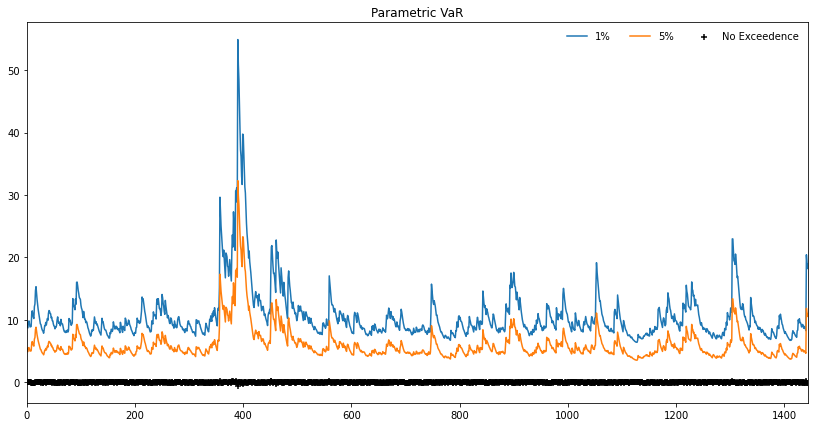

In [21]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]

print("5% chance of losing", str(value_at_risk[-1:][0][0]), "% of portfolio")
print("1% chance of losing", str(value_at_risk[-1:][0][1]), "% of portfolio")

value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
ret = df['Return (%)'].copy()
ret.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if ret[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif ret < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': '+'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        ret.index[sel],
        -ret.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)